In [1]:
import sys
from datetime import datetime

from catppuccin.extras.rich_ctp import mocha
from rich import pretty
from rich.console import Console
from rich.pretty import pprint

pretty.install()

if ".." not in sys.path:
    sys.path.insert(0, "..")

from src.config.settings import get_settings
from src.utils.logger import create_logger

console = Console(theme=mocha)
settings = get_settings()
logger = create_logger(path=settings.paths.logs_dir)
logger.debug(f"settings loaded as \n{settings.model_dump_json(indent=2)}")

12:34 AM | 2468537737.L:20  | DEBUG     | settings loaded as 
{
  "models": {
    "hf": {
      "chat": "meta-llama/Llama-3.2-3B-Instruct:together",
      "reasoning": "zai-org/GLM-4.7-Flash:novita",
      "structured_output": "Qwen/Qwen3-Coder-30B-A3B-Instruct:ovhcloud",
      "embedding_snowflake": "Snowflake/snowflake-arctic-embed-l-v2.0",
      "embedding_specter": "allenai/specter2_base",
      "encoder": "m3rg-iitd/matscibert",
      "reranker": "Qwen/Qwen3-Reranker-0.6B",
      "router": "openai/gpt-oss-20b:together"
    },
    "nebius": {
      "reasoning": "zai-org/GLM-4.5-Air",
      "tool_user": "Qwen/Qwen3-30B-A3B-Instruct-2507",
      "chat": "meta-llama/Meta-Llama-3.1-8B-Instruct-fast",
      "embedding_baai_bge": "BAAI/bge-multilingual-gemma2",
      "router": "openai/gpt-oss-20b"
    }
  },
  "paths": {
    "base_dir": "/home/rudy/code/lattice/src",
    "data_dir": "/home/rudy/code/lattice/src/data",
    "logs_dir": "/home/rudy/code/lattice/src/logs",
    "agents_dir": 

In [2]:
from typing import Annotated, Dict, List, Optional, TypedDict

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.types import Command, interrupt
from pydantic import BaseModel, Field
from pydantic.json_schema import SkipJsonSchema

In [3]:
from src.backends.virtual_filesystem import VirtualFilesystem
from src.prompts import (
    planning_mode_systemm_prompt,
    planning_structured_output,
)
from src.schemas import RESEARCH_PLAN_TEMPLATE, ResearchPlan
from src.tools.filesystem_tools import create_filesystem_tools
from src.utils.printer import ChatPrinter
from src.utils.stats import accumulate_usage, add_usage_metadata

version = "0.0.1-alpha"

In [4]:
planning_structured_output.expected_outputs = f"""Generate a valid JSON object as per provided <SCHEMA>. The equivalent markdown would look like the following:
```markdown
{RESEARCH_PLAN_TEMPLATE.to_markdown()}
```
"""
planning_mode_systemm_prompt.version = version

In [5]:
print(planning_structured_output.to_markdown())

# Research Plan Structured Output Extractor: SYSTEM PROMPT

## PROFILE
- NAME: Assistant
- ROLE: Research Plan Structured Output Extractor
- DESCRIPTION: You are an assistant who specialises in extracting the research plan in a structured format according to the schema provided in <EXPECTED OUTPUTS> and <SCHEMA>.
- MODE: ASK
- DATE: February 2026

## TRAITS
Your core traits are:
- helpful
- friendly

## TOOLS
None - You do not have access to any tools yet.

## SKILLS
None - You do not have access to any skills yet.

## DOMAIN KNOWLEDGE
None - You do not have any domain knowledge yet.

## WORKFLOW
1. You will read the provided AIMessage carefully.
2. You will determine if the provided message contains the research plan or not.
3. If the message contains the research plan, you will extract it in a structured format according to the provided <EXPECTED OUTPUT> as per <RESPONSE GUIDELINES>.
4. If the message does not contain the research plan, you will leave all the fields blank (as set in 

In [25]:
printer = ChatPrinter(console=console)
vfs = VirtualFilesystem()
filesystem_tools = create_filesystem_tools(vfs)

In [6]:
class UsageMetadata(TypedDict):
    input_tokens: int
    output_tokens: int
    total_tokens: int
    input_token_details: dict
    output_token_details: dict


class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    is_plan_approved_by_user: bool = False
    usage_metadata: Annotated[UsageMetadata, add_usage_metadata] = {
        "input_tokens": 0,
        "output_tokens": 0,
        "total_tokens": 0,
        "input_token_details": {},
        "output_token_details": {},
    }

# Design the graph


In [10]:
chat_llm = ChatOpenAI(
    model=settings.models.hf.chat,
    base_url=settings.env.HF_API_ENDPOINT,
    api_key=settings.env.HF_API_KEY,
    max_completion_tokens=8192,
    temperature=0.0,
    top_p=0.7,
    streaming=True,
)
structured_research_plan_llm = ChatOpenAI(
    model=settings.models.hf.structured_output,
    base_url=settings.env.HF_API_ENDPOINT,
    api_key=settings.env.HF_API_KEY,
    max_completion_tokens=8192,
    temperature=0.0,
    top_p=1,
).with_structured_output(ResearchPlan, include_raw=True, method="json_mode")
reasoning_llm = ChatOpenAI(
    model=settings.models.hf.reasoning,
    base_url=settings.env.HF_API_ENDPOINT,
    api_key=settings.env.HF_API_KEY,
    max_completion_tokens=8192,
    temperature=0.0,
    top_p=0.7,
)

In [ ]:
def chat_and_planner_node(state: AgentState) -> AgentState | Dict:
    printer.debug("entering chat_and_planner_node.")
    SYSTEM_PROMPT = planning_mode_systemm_prompt.format(
        date=datetime.now().strftime("%B %Y"), version=version
    )
    full_context = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    # full_context = state["messages"]
    response = chat_llm.invoke(full_context)
    return {"messages": response, "usage_metadata": response.usage_metadata}


def user_review_and_feedback_node(state: AgentState) -> AgentState | Dict:
    """this node recieves the research plan that has been properly generated. now its time to ask the user for feedback or approve the plan.

    Values expected in user_feedback:
    - human: str
    - is_approved: bool

    Args:
        state (AgentState): the graph state

    Returns:
        AgentState | Dict: the returned value
    """
    printer.debug("entering user_review_and_feedback_node")
    # else if the plan is not approved ask for feedback or approval
    user_feedback = interrupt(
        {
            "interrupt_node": "user_review_and_feedback_node",
            "interrupt_message": "",
            "messages": state["messages"],
        }
    )
    if user_feedback.get("is_approved", False):
        # this needs to go to survey again
        return {
            "messages": [
                SystemMessage(
                    content="The research plan has been approved by the user with feedback."
                ),
                HumanMessage(content=user_feedback.get("human", "")),
            ],
            "is_plan_approved_by_user": True,
        }
    else:
        # so the user did not approve. append the feedback and send back to the planner
        return {
            "messages": HumanMessage(content=user_feedback.get("human", "")),
            "is_plan_approved_by_user": False,
        }


def edit_plan_or_survey_router(state: AgentState) -> AgentState | str:
    printer.debug("entering edit_plan_or_survey_router")
    if state["is_plan_approved_by_user"]:
        logger.info("Plan approved. Proceeding with survey.")
        return "survey"
    else:
        logger.info("Plan not approved. Reviewing.")
        return "plan"


def survey_node(state: AgentState) -> AgentState | Dict:
    logger.debug("Entering survey_node")
    return {"messages": AIMessage(content="Surveying...")}

In [12]:
graph = StateGraph(AgentState)
graph.add_node("chat_and_planner_node", chat_and_planner_node)
graph.add_node("user_review_and_feedback_node", user_review_and_feedback_node)
graph.add_node("survey_node", survey_node)
graph.add_edge(START, "chat_and_planner_node")
graph.add_edge("chat_and_planner_node", "user_review_and_feedback_node")
graph.add_conditional_edges(
    "user_review_and_feedback_node",
    edit_plan_or_survey_router,
    {"survey": "survey_node", "plan": "chat_and_planner_node"},
)
graph.add_edge("survey_node", END)
checkpointer = MemorySaver()
agent = graph.compile(checkpointer=checkpointer)

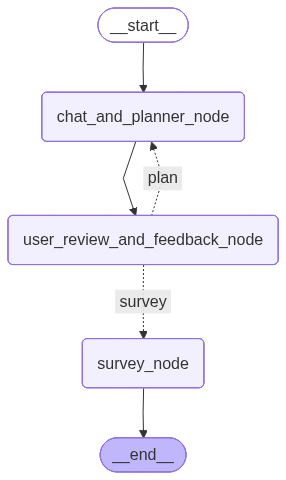

In [13]:
agent

In [14]:
config = {"configurable": {"thread_id": "thread-1"}}

In [139]:
updates = []
for mode, chunk in agent.stream(
    {"messages": HumanMessage(content="who are you?")},
    config=config,
    stream_mode=["messages", "updates"],
):
    if mode == "messages":
        print(chunk[0].content, end="", flush=True)
    else:
        updates.append(chunk)

02:13 AM | 480268963 .L:2   | DEBUG     | entering chat_and_planner_node.


I am Lattice, a Literature Survey Agent. I am a research assistant designed to help doctoral students conduct a literature survey in a given field. I possess deep knowledge of Condensed Matter Physics and Material Science, specifically focusing on Solid State Physics and Thin Film technology. I can provide information on deposition techniques, characterization methods, and material properties, and I can help you identify relevant research papers and organize the findings. I am here to support you in your academic research and provide guidance on how to conduct a thorough and effective literature survey.

02:13 AM | 480268963 .L:25  | DEBUG     | entering user_review_and_feedback_node


In [140]:
updates


[
    {
        'chat_and_planner_node': {
            'messages': AIMessage(
                content='I am Lattice, a Literature Survey Agent. I am a research assistant designed to help doctoral students conduct a literature survey in a given field. I possess deep knowledge of Condensed Matter Physics and Material Science, specifically focusing on Solid State Physics and Thin Film technology. I can provide information on deposition techniques, characterization methods, and material properties, and I can help you identify relevant research papers and organize the findings. I am here to support you in your academic research and provide guidance on how to conduct a thorough and effective literature survey.',
                additional_kwargs={},
                response_metadata={
                    'finish_reason': 'stop',
                    'model_name': 'meta-llama/Llama-3.2-3B-Instruct-Turbo',
                    'model_provider': 'openai'
                },
                id='lc

In [141]:
state = agent.get_state(config)

In [143]:
state.values["usage_metadata"]


{
    'input_tokens': 3520,
    'output_tokens': 200,
    'total_tokens': 3720,
    'input_token_details': None,
    'output_token_details': None
}

In [77]:
update_chunks = [c for c in chunks if "updates" in c.keys()]

In [80]:
chunks[0]["messages"]


(
    AIMessageChunk(
        content='I',
        additional_kwargs={},
        response_metadata={'model_provider': 'openai'},
        id='lc_run--019c2f71-4ca7-7302-9138-7d86d6c338df',
        tool_calls=[],
        invalid_tool_calls=[],
        tool_call_chunks=[]
    ),
    {
        'thread_id': 'thread-1',
        'langgraph_step': 1,
        'langgraph_node': 'chat_and_planner_node',
        'langgraph_triggers': ('branch:to:chat_and_planner_node',),
        'langgraph_path': ('__pregel_pull', 'chat_and_planner_node'),
        'langgraph_checkpoint_ns': 'chat_and_planner_node:ff5035b5-9278-012d-dc8f-fad89554135a',
        'checkpoint_ns': 'chat_and_planner_node:ff5035b5-9278-012d-dc8f-fad89554135a',
        'ls_provider': 'openai',
        'ls_model_name': 'meta-llama/Llama-3.2-3B-Instruct:together',
        'ls_model_type': 'chat',
        'ls_temperature': 0.0,
        'ls_max_tokens': 8192,
        'LANGSMITH_PROJECT': 'Lattice',
        'LANGSMITH_TRACING': 'true',
      

In [82]:
update_chunks[1]["updates"]


{
    '__interrupt__': (
        Interrupt(
            value={
                'interrupt_node': 'user_review_and_feedback_node',
                'interrupt_message': '',
                'messages': [
                    HumanMessage(
                        content='who are you?',
                        additional_kwargs={},
                        response_metadata={},
                        id='0b7c8f7b-bb10-4454-ac91-79b0002551f9'
                    ),
                    AIMessage(
                        content='I am Lattice, a Literature Survey Agent. My mission is to assist a doctoral student in conducting a literature survey in a given field. I am a research-focused agent, and my primary goal is to provide accurate and reliable information to aid in the research process. I am here to help you with your literature survey needs.',
                        additional_kwargs={},
                        response_metadata={
                            'finish_reason': 'stop',
 

In [93]:
response = agent.invoke(
    {"messages": HumanMessage(content="Who are you?")},
    config=config,
)

01:58 AM | 2998125648.L:2   | DEBUG     | entering chat_and_planner_node.
01:58 AM | 2998125648.L:25  | DEBUG     | entering user_review_and_feedback_node


In [94]:
response


{
    'messages': [
        HumanMessage(
            content='Who are you?',
            additional_kwargs={},
            response_metadata={},
            id='4b5c251d-bbff-4f34-906a-5614b89ea2ea'
        ),
        AIMessage(
            content='I am Lattice, a Literature Survey Agent. I am here to assist you with conducting a literature survey in your chosen field of research. My mission is to provide you with a solid foundation of existing research and knowledge in your area of interest. I strive to maintain academic rigor and provide empathetic support throughout our conversation.',
            additional_kwargs={},
            response_metadata={
                'finish_reason': 'stop',
                'model_name': 'meta-llama/Llama-3.2-3B-Instruct-Turbo',
                'model_provider': 'openai'
            },
            id='lc_run--019c2f7e-56eb-7853-9404-94b372345b2c',
            tool_calls=[],
            invalid_tool_calls=[],
            usage_metadata={
          

In [52]:
response["messages"][1].pretty_print()

================================== Ai Message ==================================

# RESEARCH PLAN

## Title
Investigating the Effects of Cuprate Thin Films on the Optical and Electrical Properties of ZnO

## Keywords
ZnO, cuprates, thin film deposition, optical properties, electrical properties

## Summary
This research plan aims to investigate the effects of cuprate thin films on the optical and electrical properties of ZnO. Cuprates are known for their high superconducting transition temperatures and have been used in various applications, including thin film deposition on semiconductor materials like ZnO. The goal of this research is to explore the potential of cuprate thin films to enhance the optical and electrical properties of ZnO.

## Objectives

1. To deposit cuprate thin films on ZnO using various deposition techniques (PVD, CVD, MBE).
2. To investigate the optical properties of ZnO with and without cuprate thin films, including absorption, reflectance, and photoluminescence.

In [53]:
response = agent.invoke(
    Command(
        resume={
            "human": "i like this plan. lets proceed with the survey.",
            "is_approved": True,
        }
    ),
    config=config,
)

01:22 AM | 2941682256.L:24  | DEBUG     | entering user_review_and_feedback_node
01:22 AM | 2941682256.L:53  | DEBUG     | entering edit_plan_or_survey_router
01:22 AM | 2941682256.L:55  | INFO      | Plan approved. Proceeding with survey.
01:22 AM | 2941682256.L:63  | DEBUG     | Entering survey_node


In [34]:
state = agent.get_state(config)

In [36]:
state.values["is_plan_approved_by_user"]

KeyError: 'is_plan_approved_by_user'

In [ ]:
from typing import TypedDict

from langgraph.config import get_stream_writer
from langgraph.graph import START, StateGraph


class State(TypedDict):
    query: str
    answer: str


def node(state: State):
    # Get the stream writer to send custom data
    writer = get_stream_writer()
    # Emit a custom key-value pair (e.g., progress update)
    writer({"custom_key": "Generating custom data inside node"})
    return {"answer": "some data"}


graph = StateGraph(State).add_node(node).add_edge(START, "node").compile()

inputs = {"query": "example"}

# Set stream_mode="custom" to receive the custom data in the stream
for chunk in graph.stream(inputs, stream_mode="custom"):
    print(chunk)

{'custom_key': 'Generating custom data inside node'}
